# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Работа с таблицей и поиск аномалий

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
display(df.head())
df.info()


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


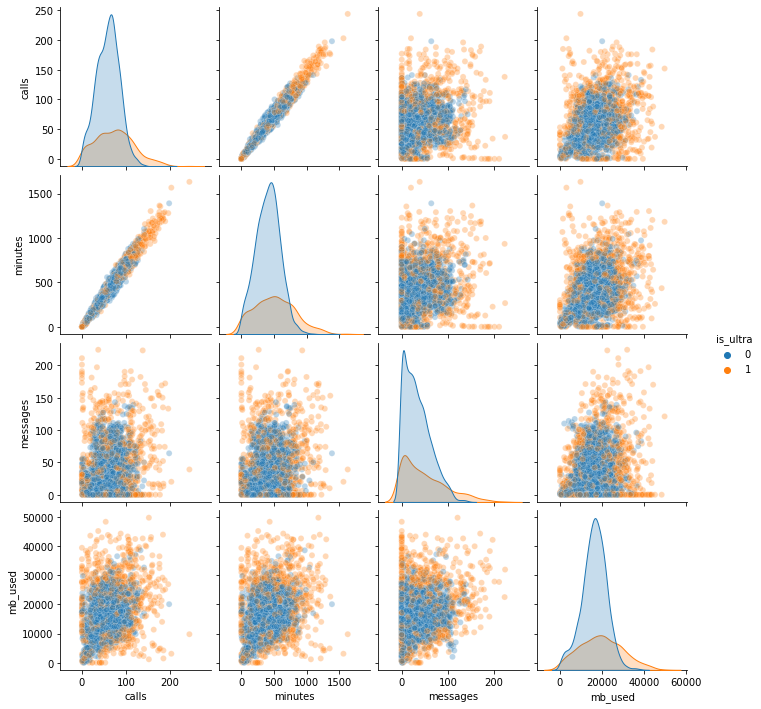

In [3]:
sns.pairplot(df, hue='is_ultra', kind='scatter', plot_kws={'alpha':0.3})
plt.show()

Данные предобработаны, пропусков нет  
Можно заметить, что пользователей с тарифом "ультра", гораздо меньше, они используют связь в среднем больше больше

## Разбивка данных на выборки

In [4]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

features_train, features_test_valid, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_test_valid, target_valid_test, test_size=0.5, random_state=12345)

display('number of rows in features_train', len(features_train))
display(
    'number of rows in features_test', len(features_test),
    'if the latter is 3 times smaller the division is done correctly'
)

'number of rows in features_train'

1928

'number of rows in features_test'

643

'if the latter is 3 times smaller the division is done correctly'

## Моделирование

In [5]:
param_grid = {
    'n_estimators': [20, 40, 60, 100, 200],
    'max_depth': [None, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid)

grid_search.fit(features_train, target_train)

print("best parameters:", grid_search.best_params_)
print("best cross-validation score:", grid_search.best_score_)
print("best estimator:", grid_search.best_estimator_)            
            
            


best parameters: {'max_depth': 10, 'n_estimators': 100}
best cross-validation score: 0.8210618397146895
best estimator: RandomForestClassifier(max_depth=10)


In [6]:
best_model = None
best_result = 0
best_depth = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = model.score(features_valid, target_valid)
    if result > best_result:
            best_depth = depth
            best_model = model 
            best_result = result
            
print("Accuracy наилучшей модели TREE CLASS на валидационной выборке:", best_result, 'depth:', best_depth)


Accuracy наилучшей модели TREE CLASS на валидационной выборке: 0.7993779160186625 depth: 7


In [7]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = model.score(features_valid, target_valid)

print("Accuracy наилучшей модели LOG REG на валидационной выборке:", result)


Accuracy наилучшей модели LOG REG на валидационной выборке: 0.6842923794712286


По итогу лучшей моделью оказалось лес решений с n_estimators=200, a depth=10

## Проверка модели на тестовой выборке

In [8]:
features = pd.concat([features_valid, features_train])
target = pd.concat([target_valid, target_train])
len(features)

2571

In [9]:
model = RandomForestClassifier(random_state=12345, n_estimators=200, max_depth=10)

model.fit(features, target)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=12345)

In [10]:
result = model.score(features_test, target_test)
print('Accuracy лучшей модели на тестовых данных:', result)

Accuracy лучшей модели на тестовых данных: 0.80248833592535


## Проверка модели на адекватность

In [11]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features, target)
print('Accuracy dummy модели:', dummy_clf.score(features_test, target_test))

Accuracy dummy модели: 0.7060653188180405


### Итоговый вывод  
Моделью с наибольшей точностью оказался лес решений с примерной точности около 0.8